<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preprocessing</a></span></li><li><span><a href="#Predictive-models" data-toc-modified-id="Predictive-models-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Predictive models</a></span><ul class="toc-item"><li><span><a href="#Random-Forests" data-toc-modified-id="Random-Forests-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Random Forests</a></span></li><li><span><a href="#Logistic-regression" data-toc-modified-id="Logistic-regression-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Logistic regression</a></span></li><li><span><a href="#Support-Vector-Machine" data-toc-modified-id="Support-Vector-Machine-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Support Vector Machine</a></span><ul class="toc-item"><li><span><a href="#Linear-SVM" data-toc-modified-id="Linear-SVM-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Linear SVM</a></span></li><li><span><a href="#SVM-with-RBF-Kernel" data-toc-modified-id="SVM-with-RBF-Kernel-2.3.2"><span class="toc-item-num">2.3.2&nbsp;&nbsp;</span>SVM with RBF-Kernel</a></span></li><li><span><a href="#SVM-with-polynomial-kernel" data-toc-modified-id="SVM-with-polynomial-kernel-2.3.3"><span class="toc-item-num">2.3.3&nbsp;&nbsp;</span>SVM with polynomial kernel</a></span></li></ul></li></ul></li><li><span><a href="#Performance-comparison" data-toc-modified-id="Performance-comparison-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Performance comparison</a></span></li></ul></div>

In [1]:
import pdb 
import glob
import copy
import math
import pickle

import numpy as np
import pandas as pd
import scipy as sp

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
 
import missingno  # for visualizing missing data

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV, ShuffleSplit

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, \
    LogisticRegressionCV, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, classification_report, \
    precision_recall_curve, average_precision_score, f1_score, \
    roc_curve, auc, roc_auc_score, make_scorer,\
    accuracy_score, balanced_accuracy_score

from sklearn.externals import joblib
from sklearn.utils import resample
from sklearn.utils.fixes import signature


# Set up pandas table display
pd.set_option('display.width', 120)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Set plotting options
sns.set() # Use seaborn defaults for plotting
%matplotlib inline 

In [2]:
# Adjust number of CPU cores to use
n_jobs=2

In [3]:
# Load original data
with open('data_processed/all_data.pickle', 'rb') as pickled_file: 
    all_data = pickle.load(pickled_file) 

# TEMPORARY:
# ---------
# Reduce number of observations to speed up computations
n_samples=100000
all_data = resample(all_data, replace=False, 
                    n_samples=n_samples, random_state=1)


## Preprocessing

In [4]:
# Find categorical variables with more than 50 unique values and drop them
unique_values_cat = all_data.select_dtypes(include='object') \
                        .nunique() \
                        .sort_values(ascending=False) 
# Drop categorical variables with more than 50 categories
all_data = all_data.drop(unique_values_cat[unique_values_cat > 50].index,
                 axis='columns')

# Train-test split (for now only select 1% for training)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = \
    train_test_split(all_data.drop('default', axis='columns'),
                     all_data.default,
#                      train_size=0.9,
                     train_size=20000, test_size=1000,
                     random_state=1,
                     shuffle=True, stratify=all_data.default) 

# Imputation and standardization for numeric features
numeric_features = X_train.select_dtypes(include=[np.number]).columns
numeric_transformer = Pipeline(steps =[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())]) 

# Imputation and one-hot encoding for categorical features
categorical_features = X_train.select_dtypes(include=[object]).columns
categorical_transformer = Pipeline(steps =[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combining preprocessing for both kinds of features
# (Features of other dtypes – in our case, boolean – will be
# appended at the end without transformation.)
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric_transformer', 
             numeric_transformer, numeric_features),
        ('categorical_transformer', 
             categorical_transformer, categorical_features)],
    remainder='passthrough', n_jobs=n_jobs)

# Print dtypes of untransformed data
print('data types of columns that were not transformed:\n {}'
        .format(X_train.select_dtypes(exclude=[np.number, object]) \
                .dtypes.unique()))

# Apply preprocessing
X_train_p = preprocessor.fit_transform(X_train)
X_test_p = preprocessor.transform(X_test)

data types of columns that were not transformed:
 [dtype('bool')]


## Predictive models

In [5]:
# Dictionaries to store results
average_precision = {}
classification_reports = {}
most_important_features = {}

### Random Forests

In [6]:
rf = RandomForestClassifier(n_estimators=100, 
        oob_score=False, n_jobs=n_jobs, random_state=1,
        class_weight='balanced_subsample')
rf.fit(X_train_p, y_train)

# Predictions of class and probability
y_pred_rf = rf.predict(X_test_p) 
y_pred_proba_rf = rf.predict_proba(X_test_p)[:, 1]

# Save results
average_precision['random forests'] = \
    average_precision_score(y_test, y_pred_proba_rf)
classification_reports['random forests'] = \
    classification_report(y_test, y_pred_rf)

# Save most important features
# First get a list of feature names for each dtype
categorical_names = preprocessor \
    .named_transformers_['categorical_transformer'] \
    .named_steps['onehot'] \
    .get_feature_names()
other_names = X_train \
    .select_dtypes(exclude=[np.number, object]) \
    .columns
# Concatenate feature names
feature_names = \
    list(numeric_features) + list(categorical_names) + \
        list(other_names) 
# Compute feature importance and sort
most_important_features['random forests'] = \
    pd.Series(rf.feature_importances_, index=feature_names) \
            .sort_values(ascending=False) \
            .iloc[: 10]

### Logistic regression

In [123]:
# Logistic regression (Elastic Net) 
# --------------------------------
lr = SGDClassifier(loss='log', penalty='elasticnet', 
                      class_weight='balanced', 
                      max_iter=1000, tol=1E-3, # those are defaults for sklearn 0.21+
                      random_state=1, n_jobs=n_jobs) 

# Parameters to search over
param_grid = {'l1_ratio': np.linspace(0, 1, 11),
              'alpha': np.logspace(-6, 1, 8)}
# Grid search
lr_gs = GridSearchCV(lr, param_grid=param_grid, 
                     scoring='average_precision',
                     return_train_score=True,
                     n_jobs=n_jobs, cv=3)
lr_gs.fit(X_train_p, y_train) 

# Predictions
y_pred_lr = lr_gs.predict(X_test_p)    
y_pred_proba_lr = lr_gs.predict_proba(X_test_p)[:, 1]

# Save results
average_precision['logistic regression'] = \
    average_precision_score(y_test, y_pred_proba_lr)
classification_reports['logistic regression'] = \
    classification_report(y_test, y_pred_lr)

# Compute feature importance and sort
most_important_features['logistic regression'] = \
    pd.Series(lr_gs.best_estimator_.coef_[0], 
          index=feature_names) \
    .sort_values(ascending=False) \
    .iloc[: 10] 

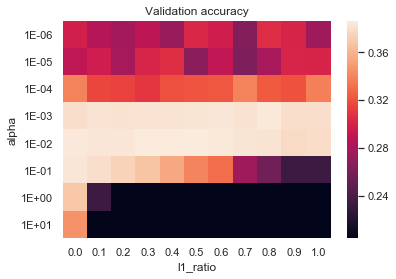

In [201]:
# Visualize grid search results
def gs_heatmap(gridsearchcv, x_digits=0, y_digits=0,
               x_scientific_notation=True, y_scientific_notation=True):
    """Visualizes validation accuracy from grid search over two hyperparameters."""
    
    # Get mean validation scores
    scores = pd.DataFrame(
        gridsearchcv.cv_results_['mean_test_score'])
    # Get values for hyperparameters
    params = pd.DataFrame(
        gridsearchcv.cv_results_['params'])
    # Concatenate validation scores and hyperparameters 
    scores_w_params = pd.concat([params, scores], 
                                  axis=1)
    # Set first two columns, which correspond to parameters, as index.
    # Then unstack.
    index_cols = list(scores_w_params.columns)[:2]
    scores_2d = scores_w_params.set_index(index_cols) \
                    .squeeze() \
                    .unstack()
    
    # Create desired formatting string for axes (scientific notation and digits)
    if x_scientific_notation == True:
        x_notation = 'E' 
    else: 
        x_notation = 'F'
    x_formatting = '{:.' + str(x_digits) + x_notation + '}'

    if y_scientific_notation == True:
        y_notation = 'E' 
    else: 
        y_notation = 'F'
    y_formatting = '{:.' + str(y_digits) + y_notation + '}'

    # Plot
    fig, ax = plt.subplots()
    sns.heatmap(scores_2d, ax=ax,
                xticklabels=[x_formatting.format(x) for  x in scores_2d.columns],
                yticklabels=[y_formatting.format(y) for y in scores_2d.index])
    ax.set_title('Validation accuracy')
    
gs_heatmap(lr_gs, x_digits=1, x_scientific_notation=False)

In [ ]:
# Save model
joblib.dump(svm_lin_gs, 'svm_lin_gs.joblib')

In [125]:
# Score of best model
lr_gs.best_score_

0.3862401422501458

In [134]:
# Save model
joblib.dump(lr_gs, 'lr_gs.joblib')

['lr_gs.joblib']

### Support Vector Machine
#### Linear SVM

In [122]:
# Linear SVM
# ----------
# Elastic net, logistic regression (Loss='hinge')
svm_lin = SGDClassifier(loss='hinge', penalty='elasticnet', random_state=1,
                        max_iter=1000, tol=1E-3,
                        class_weight='balanced', n_jobs=n_jobs) 

# Parameters to search over
param_grid = {'l1_ratio': np.linspace(0, 1, 11),
              'alpha': np.logspace(-5, 1, 11)}
svm_lin_gs = GridSearchCV(svm_lin, param_grid=param_grid,
                          scoring='average_precision',
                          return_train_score=True,       
                          n_jobs=n_jobs, cv=2)
svm_lin_gs.fit(X_train_p, y_train)

# Prediction of class
y_pred_svm = svm_lin_gs.predict(X_test_p)
# Distance from separating hyperplane
y_pred_distance_svm = svm_lin_gs.decision_function(X_test_p)

# Save results
average_precision['SVM (Linear Kernel)'] = \
    average_precision_score(y_test, y_pred_distance_svm)
classification_reports['SVM (Linear Kernel)'] = \
    classification_report(y_test, y_pred_svm)

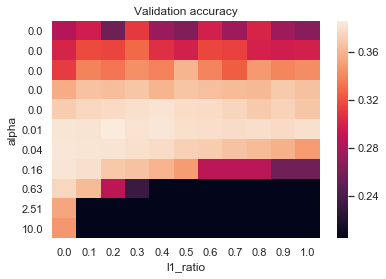

In [168]:
gs_heatmap(svm_lin_gs)

In [133]:
# Save model
joblib.dump(svm_lin_gs, 'svm_lin_gs.joblib')

['svm_lin_gs.joblib']

#### SVM with RBF-Kernel

In [81]:
svm_rbf = SVC(kernel='rbf', probability=False, 
              cache_size=5000, class_weight='balanced')
# Parameters to search over
param_grid = {'C': np.logspace(-3, 3, 8),
              'gamma': np.logspace(-5, 1, 8)}
# Define indices for validation split (instead of proper cross-validation)
split_indices = ShuffleSplit(n_splits=1, test_size=.2, random_state=1)

svm_rbf_gs = GridSearchCV(svm_rbf, param_grid=param_grid,
                          return_train_score=True,
                          scoring='average_precision', cv=split_indices)
svm_rbf_gs.fit(X_train_p, y_train)

# Prediction of class
y_pred_svm = svm_rbf_gs.predict(X_test_p)

# Distance from separating hyperplane
y_pred_distance_svm = svm_rbf_gs.decision_function(X_test_p)

# Save results
average_precision['SVM (RBF Kernel)'] = \
    average_precision_score(y_test, y_pred_distance_svm)

classification_reports['SVM (RBF Kernel)'] = \
    classification_report(y_test, y_pred_svm)

GridSearchCV(cv=ShuffleSplit(n_splits=1, random_state=1, test_size=0.2, train_size=None),
       error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=5000, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': array([1.00000e-03, 5.17947e-03, 2.68270e-02, 1.38950e-01, 7.19686e-01,
       3.72759e+00, 1.93070e+01, 1.00000e+02]), 'gamma': array([1.00000e-03, 3.72759e-03, 1.38950e-02, 5.17947e-02, 1.93070e-01,
       7.19686e-01, 2.68270e+00, 1.00000e+01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='average_precision', verbose=0)

In [84]:
pd.DataFrame(svm_rbf_gs.cv_results_) \
    .set_index('params') \
    .loc[:,['mean_test_score', 'mean_train_score',
           'split0_test_score', 'split1_test_score','split2_test_score',
           'split0_train_score', 'split1_train_score','split2_train_score']] 

C:\Users\t\Anaconda3\lib\site-packages\pandas\core\indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,mean_test_score,mean_train_score,split0_test_score,split1_test_score,split2_test_score,split0_train_score,split1_train_score,split2_train_score
params,,,,,,,,
"{'C': 0.001, 'gamma': 0.001}",0.341731,0.350184,0.341731,NaN,NaN,0.350184,NaN,NaN
"{'C': 0.001, 'gamma': 0.003727593720314938}",0.348639,0.356863,0.348639,NaN,NaN,0.356863,NaN,NaN
"{'C': 0.001, 'gamma': 0.013894954943731374}",0.356746,0.367547,0.356746,NaN,NaN,0.367547,NaN,NaN
"{'C': 0.001, 'gamma': 0.0517947467923121}",0.347594,0.411679,0.347594,NaN,NaN,0.411679,NaN,NaN
"{'C': 0.001, 'gamma': 0.19306977288832497}",0.310183,0.992965,0.310183,NaN,NaN,0.992965,NaN,NaN
"{'C': 0.001, 'gamma': 0.7196856730011514}",0.237501,1.000000,0.237501,NaN,NaN,1.000000,NaN,NaN
"{'C': 0.001, 'gamma': 2.6826957952797246}",0.199725,1.000000,0.199725,NaN,NaN,1.000000,NaN,NaN
"{'C': 0.001, 'gamma': 10.0}",0.199950,1.000000,0.199950,NaN,NaN,1.000000,NaN,NaN
"{'C': 0.005179474679231213, 'gamma': 0.001}",0.341731,0.350184,0.341731,NaN,NaN,0.350184,NaN,NaN


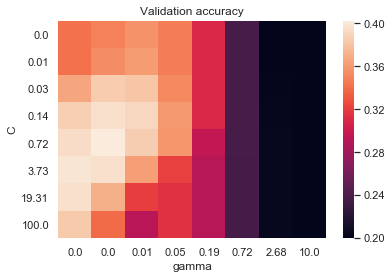

In [169]:
gs_heatmap(svm_rbf_gs)

In [132]:
# Save model
joblib.dump(svm_rbf_gs, 'svm_rbf_gs.joblib')

['svm_rbf_gs.joblib']

#### SVM with polynomial kernel 

In [127]:
svm_poly = SVC(kernel='poly', probability=False, gamma='auto',
              cache_size=5000, class_weight='balanced')
# Parameters to search over
param_grid = {'C': np.logspace(-3, 3, 8),
              'degree': [2,3,4]}
# Define indices for validation split (instead of proper cross-validation)
split_indices = ShuffleSplit(n_splits=1, test_size=.2, random_state=1)

svm_poly_gs = GridSearchCV(svm_poly, param_grid=param_grid,
                          return_train_score=True,
                          scoring='average_precision', cv=split_indices)
svm_poly_gs.fit(X_train_p, y_train)

C:\Users\t\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\t\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\t\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\t\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default 

GridSearchCV(cv=ShuffleSplit(n_splits=1, random_state=1, test_size=0.2, train_size=None),
       error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=5000, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='poly', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': array([1.00000e-03, 7.19686e-03, 5.17947e-02, 3.72759e-01, 2.68270e+00,
       1.93070e+01, 1.38950e+02, 1.00000e+03]), 'degree': [2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='average_precision', verbose=0)

In [128]:
# Prediction of class
y_pred_svm_poly = svm_poly_gs.predict(X_test_p)

# Distance from separating hyperplane
y_pred_distance_svm_poly = svm_poly_gs.decision_function(X_test_p)

# Save results
average_precision['SVM (POlynomial Kernel)'] = \
    average_precision_score(y_test, y_pred_distance_svm_poly)

classification_reports['SVM (Polynomial Kernel)'] = \
    classification_report(y_test, y_pred_svm_poly)

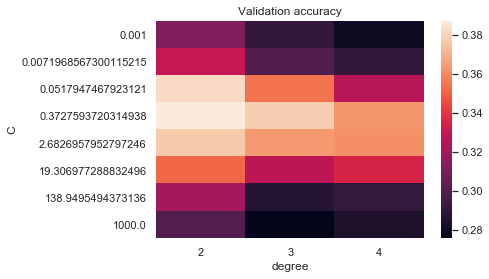

In [130]:
gs_heatmap(svm_poly_gs)

In [131]:
# Save model
joblib.dump(svm_poly_gs, 'svm_poly_gs.joblib')

['svm_poly_gs.joblib']

## Performance comparison

In [105]:
average_precision

{'random forests': 0.359015759861822,
 'logistic regression': 0.33341452868462773,
 'SVM': 0.38039619604684444,
 'SVM (RBF Kernel)': 0.3828736874537886,
 'SVM (Linear Kernel)': 0.35703402288493236}

In [ ]:
average_precision = 
plt.title('Impact of Dropping Columns on Classifier Performance')
plt.ylabel('Average Precision');